In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Visualize Pacman Logs

Before using this notebook execute `pacman_parse.py`, to create the csv from the original logs.

In [4]:
df = pd.read_csv("data/pacman_history.csv", parse_dates=["timestamp"])
df

,package,timestamp,action,version_before,version_after
0,linux-api-headers,2016-03-12 12:53:00,installed,NaN,4.4.1-1
1,tzdata,2016-03-12 12:53:00,installed,NaN,2016a-1
2,iana-etc,2016-03-12 12:53:00,installed,NaN,20151016-1
3,filesystem,2016-03-12 12:53:00,installed,NaN,2015.09-1
4,glibc,2016-03-12 12:53:00,installed,NaN,2.23-1
...,...,...,...,...,...
59650,webkit2gtk-4.1,2025-09-07 20:11:20,upgraded,2.48.5-1,2.48.6-1
59651,webkitgtk-6.0,2025-09-07 20:11:21,upgraded,2.48.5-1,2.48.6-1
59652,wireplumber,2025-09-07 20:11:21,upgraded,0.5.10-1,0.5.11-1
59653,xcb-util-cursor,2025-09-07 20:11:21,upgraded,0.1.5-1,0.1.6-1


The csv contains a line for each pacman action related to a package, it contains

- package: The package name
- timestamp: The time of the action
- action: The executed action can be `installed|upgraded|removed|reinstalled`
- version_before: empty if action is `installed`
- version_after: empty if actioin is `removed`

## Packages

Let's have some basic look at the packages

In [5]:
df.describe()

,timestamp
count,59655
mean,2021-07-07 02:17:57.412672768
min,2016-03-12 12:53:00
25%,2019-10-08 20:26:00
50%,2021-04-15 21:41:57
75%,2023-08-11 11:02:08
max,2025-09-07 20:11:21


In total there are 59655 lines of package actions, dating from March 12 2016 to September 7 2025. This should give some data to work with.

In [22]:
pkg_dist = df.groupby("package")["action"].count()
pkg_dist.describe()

count    2649.000000
mean       22.519819
std        42.018245
min         1.000000
25%         4.000000
50%        10.000000
75%        21.000000
max       535.000000
Name: action, dtype: float64

<Axes: >

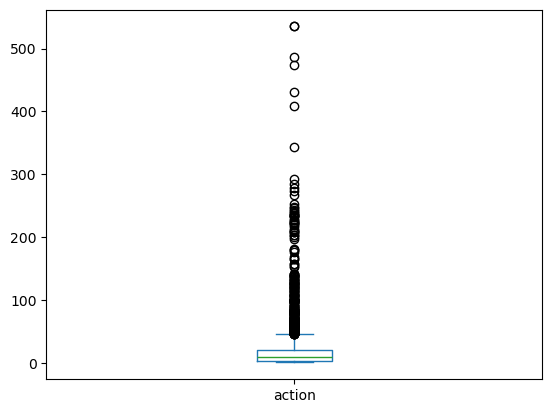

In [24]:
pkg_dist.plot.box()

So half of the packages got no more then 10 actions over the whole time, with a few packages having up to 535 actions of the whole time. Let's make this a bit more detailed, by dividing it by action

## Package actions

In [40]:
action_counts = df["action"].value_counts()
action_counts

action
upgraded       53867
installed       3551
removed         1999
reinstalled      238
Name: count, dtype: int64

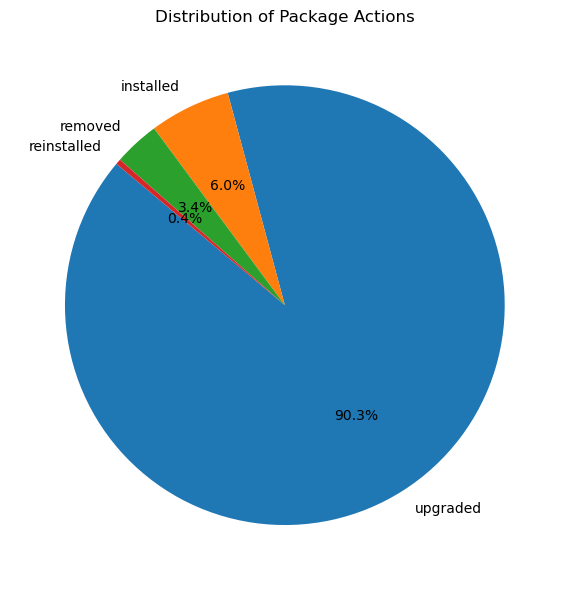

In [35]:
plt.figure(figsize=(6, 6))
action_counts.plot(kind="pie", autopct="%1.1f%%", startangle=140)
plt.title("Distribution of Package Actions")
plt.ylabel("")
plt.tight_layout()

So most of the actions are actually upgrades.  Seems kind of obvious, if you are not installing/removing packages very frequently. Let's see, which packages are on top in each of the four action categories:

In [37]:
df.groupby("action")["package"].describe()

,count,unique,top,freq
action,,,,
installed,3551,2649,gendesk,22
reinstalled,238,143,st,37
removed,1999,1342,gendesk,22
upgraded,53867,2226,linux,534


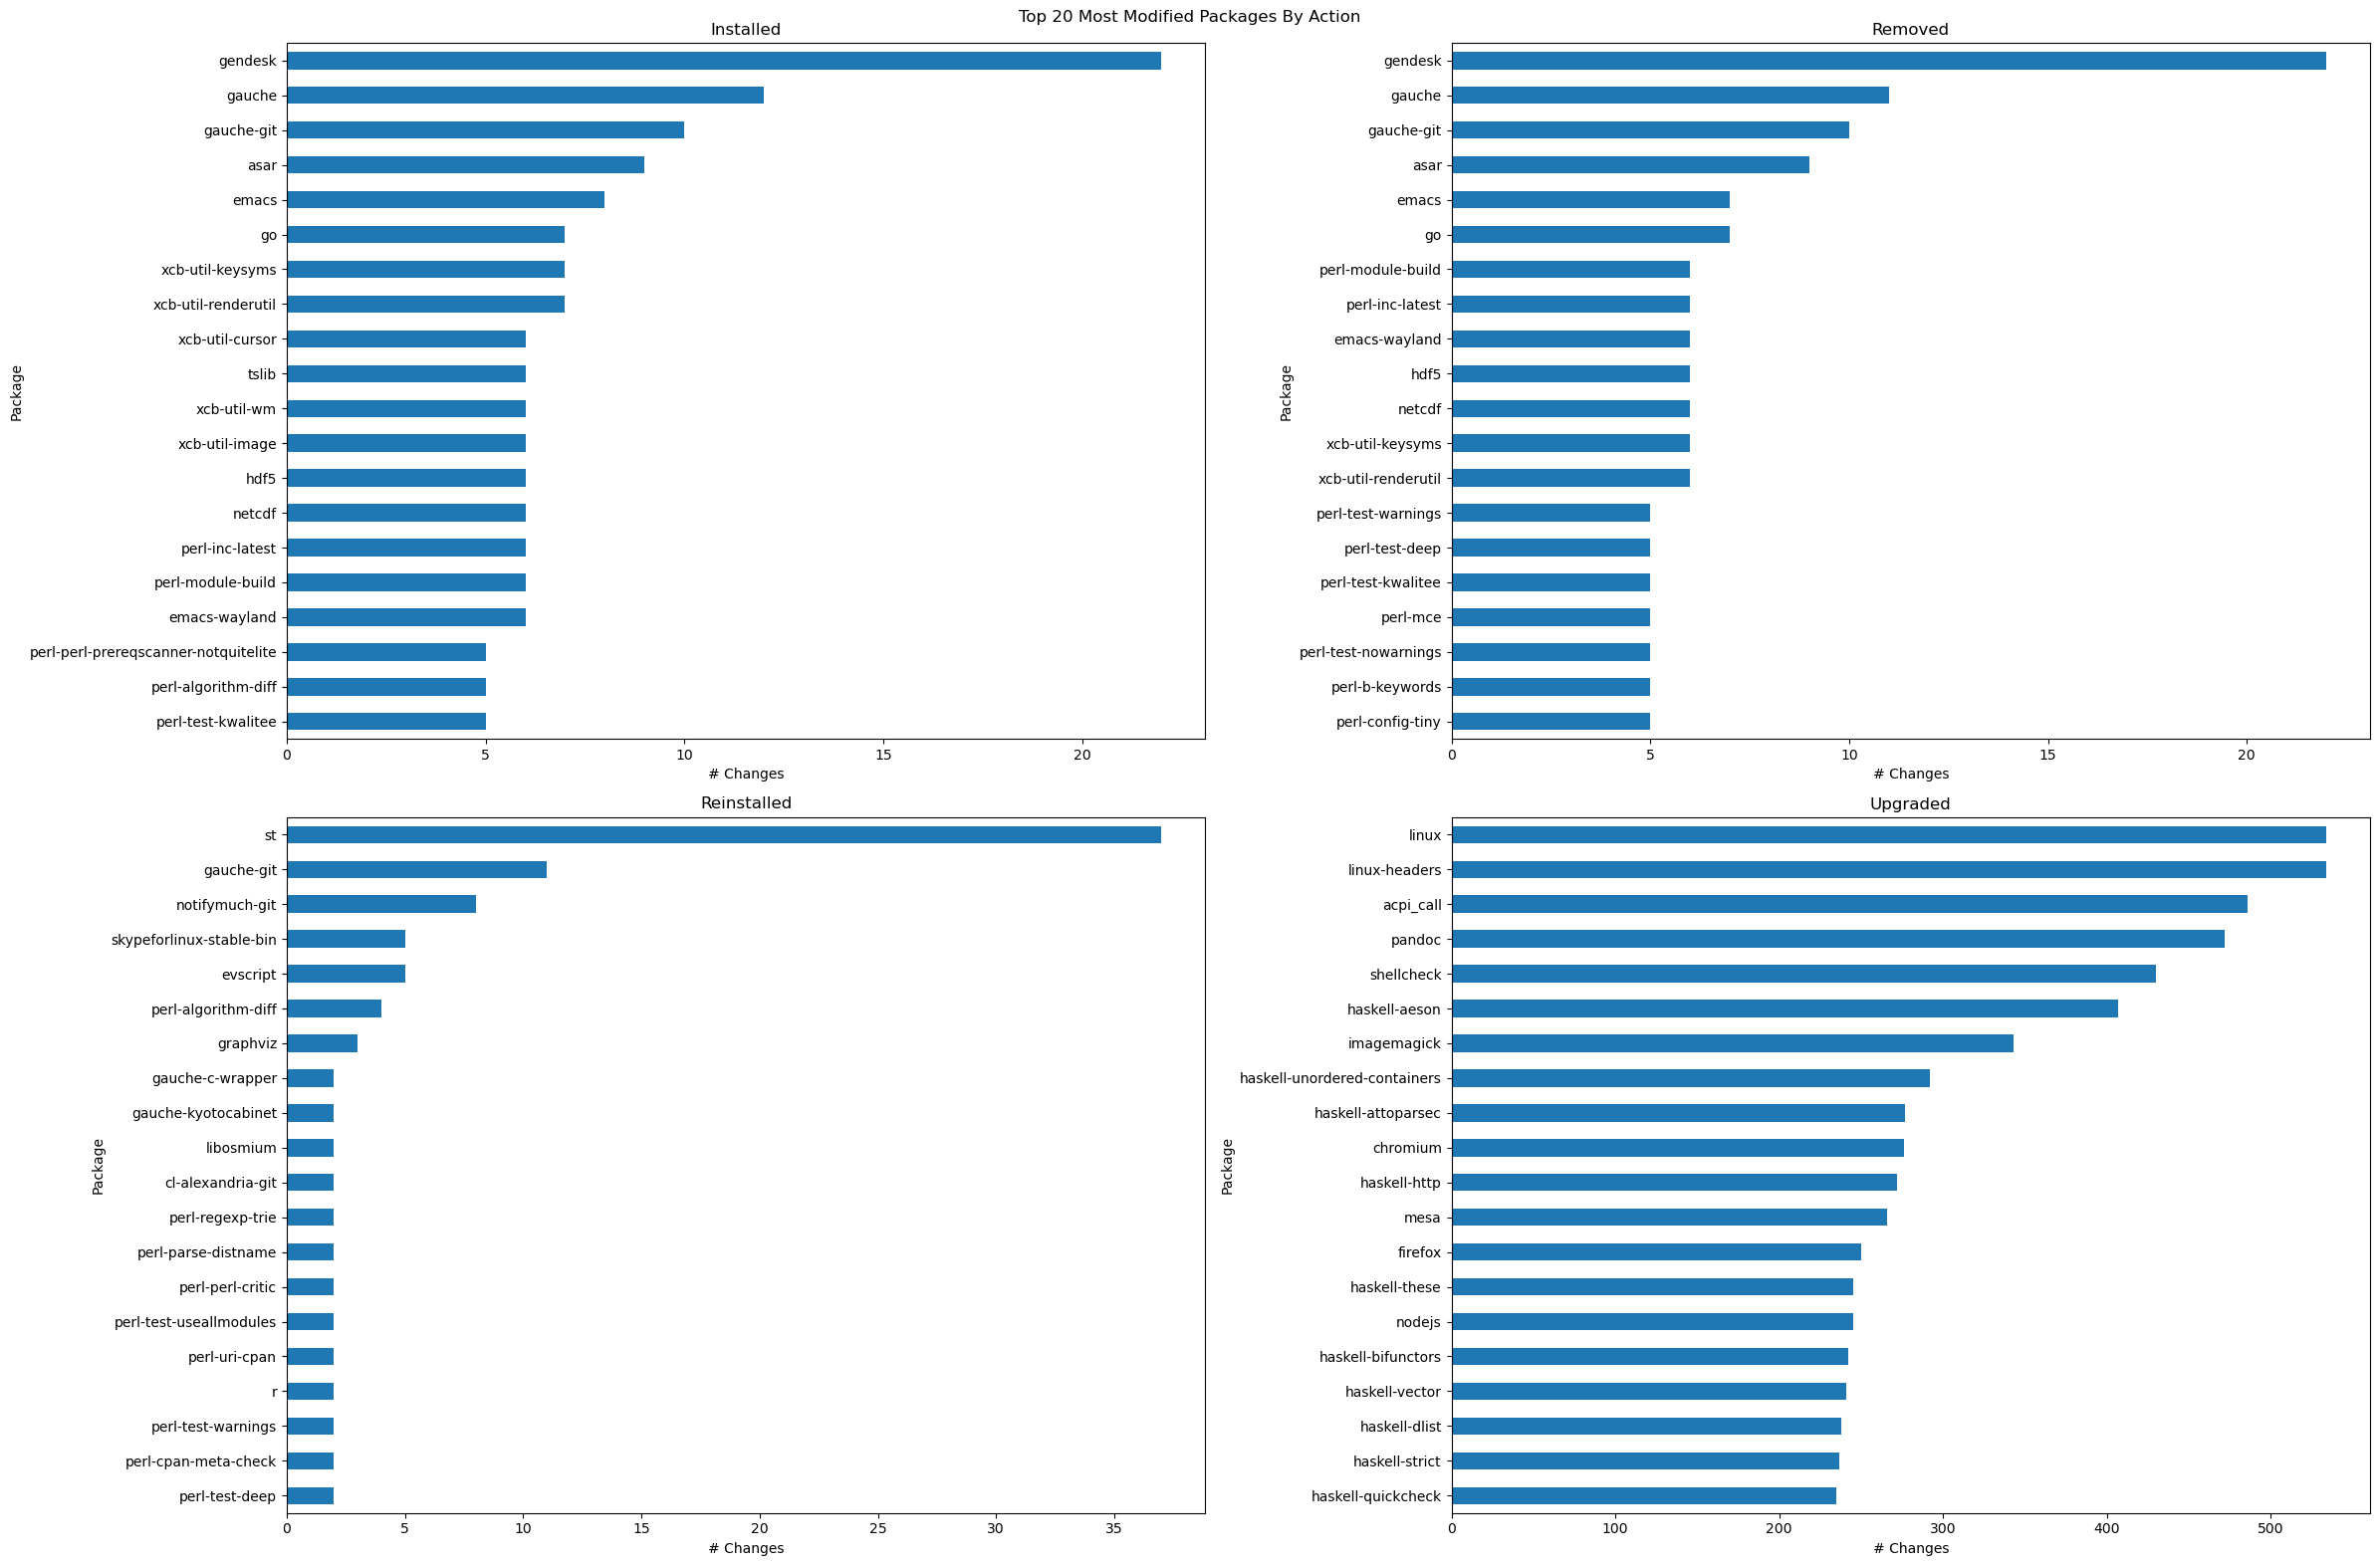

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(24, 16))
axes = axes.flatten()
for i, action in enumerate(df["action"].unique()):
    data = df[df["action"] == action]["package"].value_counts().head(20)
    data.plot(kind="barh", ax=axes[i], title=action.capitalize())
    axes[i].set_ylabel("Package")
    axes[i].set_xlabel("# Changes")
    axes[i].invert_yaxis()
plt.suptitle("Top 20 Most Modified Packages By Action")
plt.tight_layout()


`gendesk` is a build dependency, which I regularly remove.  Regarding `gauche` I do package this for the aur and installed/removed this a couple of times, to test it.  `st` is on top of the reinstalls, as you need to rebuild, it, whenever you update the configuration, as it is common with suckless projects.

The upgrade plot is intersting more generally, as it does not show my personal habits.  The kernel is the most updated package with qute a margin, but also browsers and `nodejs` get very regular updates.